<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to TensorFlow 2

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import time
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import tensorflow as tf
tf.keras.utils.set_random_seed(seed=42)
tf.get_logger().setLevel('ERROR')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

inputs = tf.keras.Input(shape=(28, 28), dtype=tf.float32)
h = tf.keras.layers.Rescaling(scale=1./255)(inputs)
outputs = tf.keras.layers.Reshape(target_shape=(784,))(h)
preprocessing_model = tf.keras.Model(inputs=inputs, outputs=outputs)

def get_ds(x, y, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(tensors=(x, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(y))
    ds = ds.batch(batch_size=64)
    ds = ds.map(map_func=lambda x, y: (preprocessing_model(x), y),
        num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    return ds

ds_train = get_ds(x=x_train, y=y_train, shuffle=True)
ds_test = get_ds(x=x_test, y=y_test)
ds_test.element_spec

(TensorSpec(shape=(None, 784), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.uint8, name=None))

In [5]:
@keras.saving.register_keras_serializable()
class CustomModel(tf.keras.Model):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.dense_1 = tf.keras.layers.Dense(units=64,
            activation=tf.keras.activations.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=1e-5))
        self.dropout = tf.keras.layers.Dropout(rate=0.2)
        self.dense_2 = tf.keras.layers.Dense(units=10,
            activation=tf.keras.activations.softmax)

    def call(self, inputs, training=False):
        h = self.dense_1(inputs=inputs)
        h = self.dropout(inputs=h, training=training)
        return self.dense_2(inputs=h)

training_model = CustomModel()
training_model.optimizer = tf.keras.optimizers.Adam()

In [6]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
metrics = [
    tf.keras.metrics.Mean(name='loss'),
    tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
]

@tf.function
def train_step(model, x, y):
    
    with tf.GradientTape() as tape:
        y_pred = model(inputs=x, training=True)
        loss = loss_fn(y_true=y, y_pred=y_pred)

    trainable_vars = model.trainable_variables
    grads = tape.gradient(target=loss, sources=trainable_vars)
    model.optimizer.apply_gradients(grads_and_vars=zip(grads, trainable_vars))
    
    for m in metrics:
        if m.name=='loss':
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {m.name: m.result() for m in metrics}

@tf.function
def test_step(model, x, y):

    y_pred = model(inputs=x, training=False)
    loss = loss_fn(y_true=y, y_pred=y_pred)

    for m in metrics:
        if m.name=='loss':
            m.update_state(values=loss)
        else:
            m.update_state(y_true=y, y_pred=y_pred)

    return {f'{m.name}': m.result() for m in metrics}

In [7]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
    patience=1, factor=0.9)
callbacks = tf.keras.callbacks.CallbackList(model=training_model,
    add_history=True, callbacks=[reduce_lr])

history = {
    'loss': [], 'val_loss': [],
    'accuracy': [], 'val_accuracy': []
}
num_epochs = 10
start_time = time.time()
logs = {}
callbacks.on_train_begin(logs=logs)
for epoch in range(num_epochs):
    callbacks.on_epoch_begin(epoch=epoch, logs=logs)

    for x, y in ds_train:        
        logs = train_step(model=training_model, x=x, y=y)
        
    for m in metrics:
        history[m.name].append(logs[m.name].numpy())
        m.reset_state()

    for x, y in ds_test:
        logs = test_step(model=training_model, x=x, y=y)
    
    for m in metrics:
        history[f'val_{m.name}'].append(logs[m.name].numpy())
        m.reset_state()
        
    callbacks.on_epoch_end(epoch=epoch, logs=logs)
callbacks.on_train_end(logs=logs)
training_model.summary()

print('Training duration: %.2fs'%(time.time() - start_time))

Model: "custom_model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (64, 64)               │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (64, 64)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (64, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,890 (198.79 KB)

 Trainable params: 50,890 (198.79 KB)

 Non-trainable params: 0 (0.00 B)

Training duration: 35.19s


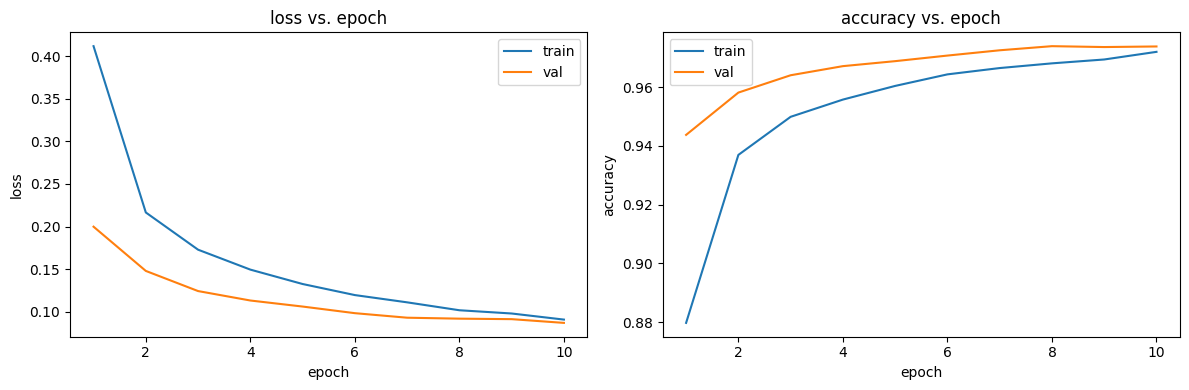

Test loss: 0.09, Test accuracy: 0.97


In [8]:
df_history = pd.DataFrame(history)
df_history['epoch'] = df_history.index + 1

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for ax, m in zip(axes, ["loss", "accuracy"]):
    g = sns.lineplot(ax=ax, data=df_history, label='train',
        x='epoch', y=f'{m}')
    g = sns.lineplot(ax=ax, data=df_history, label='val',
        x='epoch', y=f'val_{m}')
    ax.legend(loc="best")
    ax.set_xlabel(xlabel="epoch")
    ax.set_ylabel(ylabel=f"{m}")
    ax.set_title(label=f"{m} vs. epoch")
fig.tight_layout()
plt.show()

for batch, (x, y) in enumerate(ds_test):
    logs = test_step(model=training_model, x=x, y=y)
print(f'Test loss: {logs["loss"]:.2f}, Test accuracy: {logs["accuracy"]:.2f}')

In [9]:
inputs = preprocessing_model.input
outputs = training_model(preprocessing_model(inputs))
inference_model = tf.keras.Model(inputs=inputs, outputs=outputs)
os.makedirs('models', exist_ok=True)
inference_model.save('models/model.keras')

idx = 99
x_pred = np.reshape(a=x_test[idx], newshape=(1, 28, 28))
inference_model = tf.keras.models.load_model('models/model.keras')
y_pred = inference_model(x_pred)
print('y_true:', y_test[idx], 'y_pred:', np.argmax(y_pred))

y_true: 9 y_pred: 9
